# Sentiment Analysis for Mental Health
## LSTM w/ Embeddings Model and DistilBERT Transformer with LSTM Classifier Model
### Author(s): Kenneth Dolgin

#### ``Data``

https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/data



---

# Step 1: Import Libraries

In [11]:
# General Purpose Libraries
import os
import re
import pickle
from collections import Counter
import shutil
import random

# Data Manipulation and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.util import bigrams
from nltk.util import ngrams
import re
import nltk


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, Dropout, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, GRU
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import keras_tuner as kt
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, MultiHeadAttention, LayerNormalization, Add
)
from tensorflow.keras.layers import Bidirectional, Reshape
print("Updated NLTK paths:", nltk.data.path)

# Google Drive Integration (for Colab)
from google.colab import drive
drive.mount('/content/drive')

Updated NLTK paths: ['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
# Step 2: Data Loading

In [2]:
# edit the path to the project folder as needed
folder_path = '/content/drive/My Drive/Data Science/Courses/DATASCI 207 Introduction to Machine Learning/Final Project/datasci207-final-project/'

In [3]:
# get file_path
file_name = 'data/raw_data.csv'
file_path = f"{folder_path}/{file_name}"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# name columns
df.rename(columns={'Unnamed: 0': 'unique_id'}, inplace = True)

# Display the DataFrame
df.head()

,unique_id,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


---
# Step 3: Grouping Status Into New Class Labels

In [7]:
# Define the mapping for status groups
status_mapping = {
    "Normal": "Normal",
    "Depression": "Depression",
    "Suicidal": "Depression",
    # Any status not explicitly listed will default to "Class 3: Other"
}

# Apply the mapping to the status column
df['grouped_status'] = df['status'].map(status_mapping).fillna("Other")

# Encode new groups
l_encoder = LabelEncoder()
l_encoder.fit(df['grouped_status'])

df['status_encoded'] = l_encoder.transform(df['grouped_status'])
df.head()

,unique_id,statement,status,statement_len,processed_text,grouped_status,status_encoded
0,0,oh my gosh,Anxiety,3,[gosh],Other,2
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,"[trouble, sleeping, confused, mind, restless, ...",Other,2
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,"[wrong, back, dear, forward, doubt, stay, rest...",Other,2
3,3,I've shifted my focus to something else but I'...,Anxiety,11,"[shifted, focus, something, else, still, worried]",Other,2
4,4,"I'm restless and restless, it's been a month n...",Anxiety,14,"[restless, restless, month, boy, mean]",Other,2


Data Shape: Rows = 51795 , Columns = 7

Overall Distribution of Classes (3 Groups):
grouped_status
Depression    26016
Normal        15511
Other         10268
Name: count, dtype: int64

Percentages of Classes (3 Groups):
grouped_status
Depression    50.0
Normal        30.0
Other         20.0
Name: count, dtype: float64




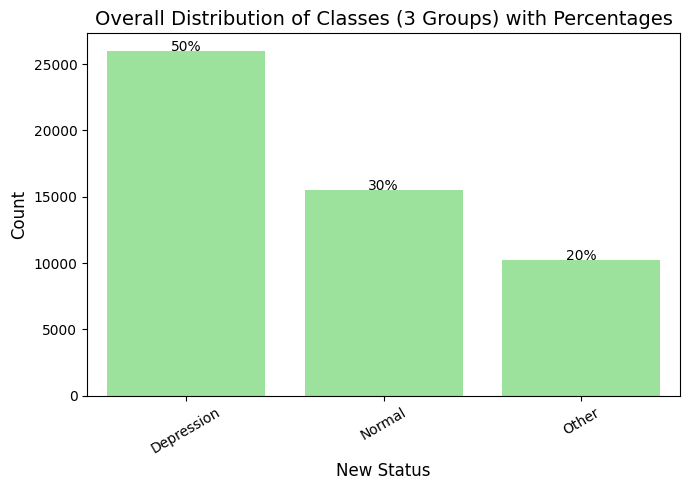

In [8]:
# calculate the overall distribution of status and percentages
status_distribution_overall = df['grouped_status'].value_counts()
status_percentages = (status_distribution_overall / df.shape[0]) * 100

# print data shape and overall status distribution with percentages
print("Data Shape: Rows =", df.shape[0], ", Columns =", df.shape[1])
print("\nOverall Distribution of Classes (3 Groups):")
print(status_distribution_overall)
print("\nPercentages of Classes (3 Groups):")
print(status_percentages.round())
print("\n")

# plot the overall status distribution with percentages
plt.figure(figsize=(7, 5))
sns.barplot(x=status_distribution_overall.index, y=status_distribution_overall.values, color='lightgreen')

# titles and labels
plt.title("Overall Distribution of Classes (3 Groups) with Percentages", fontsize=14)
plt.xlabel("New Status", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=30)

# put the percentages on the bars
for index, value in enumerate(status_distribution_overall.values):
    percentage = f"{round(status_percentages.values[index]):.0f}%"
    plt.text(index, value + 5, percentage, ha='center', fontsize=10)

plt.tight_layout()

# output
plt.show()

---
# Step 4: LSTM w/ Embeddings Model

In [9]:
# Define features and labels
X = df['statement']
y = df['grouped_status']

# Encode string labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test-validation split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [10]:
max_vocab_size = 10000
max_sequence_length = 100

vectorizer_lstm_weight = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode="int",
    output_sequence_length=max_sequence_length
)

# Adapt the TextVectorization layer to the training data
vectorizer_lstm_weight.adapt(X_train)

# Vectorize the datasets
X_train_vectorized = vectorizer_lstm_weight(X_train).numpy()
X_val_vectorized = vectorizer_lstm_weight(X_val).numpy()
X_test_vectorized = vectorizer_lstm_weight(X_test).numpy()

# Encode Labels
label_encoder_lstm_weight = LabelEncoder()
y_train_encoded = label_encoder_lstm_weight.fit_transform(y_train)
y_val_encoded = label_encoder_lstm_weight.transform(y_val)
y_test_encoded = label_encoder_lstm_weight.transform(y_test)

num_classes = len(label_encoder_lstm_weight.classes_)
y_train_categorical = to_categorical(y_train_encoded, num_classes)
y_val_categorical = to_categorical(y_val_encoded, num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weights_dict)


Class Weights: {0: 0.6636236236236236, 1: 1.1130586615627414, 2: 1.681529954852128}


In [ ]:
# LSTM Function

def build_model_lstm_weight(hp, max_vocab_size=10000, max_sequence_length=100):
    model_lstm_weight = Sequential([
        Embedding(
            input_dim=max_vocab_size,
            output_dim=hp.Int("embedding_dim", min_value=50, max_value=300, step=50),
            input_length=max_sequence_length,
            trainable=True
        ),
        LSTM(
            hp.Int("lstm_units_1", min_value=64, max_value=256, step=64),
            return_sequences=True,
            dropout=hp.Float("dropout_1", min_value=0.1, max_value=0.5, step=0.1),
            recurrent_dropout=0.2
        ),
        LSTM(
            hp.Int("lstm_units_2", min_value=32, max_value=128, step=32),
            return_sequences=False,
            dropout=hp.Float("dropout_2", min_value=0.2, max_value=0.5, step=0.1),
            recurrent_dropout=0.2
        ),
        Dense(
            hp.Int("dense_units", min_value=32, max_value=128, step=32),
            activation="relu"
        ),
        Dropout(hp.Float("dropout_dense", min_value=0.2, max_value=0.5, step=0.1)),
        Dense(num_classes, activation="softmax")
    ])

    # Compile the model with tunable learning rate
    model_lstm_weight.compile(
        optimizer=Adam(learning_rate=hp.Choice("learning_rate", values=[1e-4, 5e-4, 1e-3])),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model_lstm_weight


# Initialize the tuner
tuner = kt.BayesianOptimization(
    build_model_lstm_weight,
    objective="val_accuracy",
    max_trials=50,
    directory="hyperparameter_tuning",
    project_name="lstm_weight_tuning"
)

# Define Early Stopping
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

# Perform hyperparameter search
tuner.search(
    X_train_vectorized, y_train_categorical,
    validation_data=(X_val_vectorized, y_val_categorical),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

# Get the best hyperparameters
best_hps_lstm_weight = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hps_lstm_weight.values)

# Train the model with the best hyperparameters
model_lstm_weight = tuner.hypermodel.build(best_hps_lstm_weight)
history = model_lstm_weight.fit(
    X_train_vectorized, y_train_categorical,
    validation_data=(X_val_vectorized, y_val_categorical),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

# Evaluate the model on the test set
test_loss, test_accuracy = model_lstm_weight.evaluate(X_test_vectorized, y_test_categorical)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")



Trial 50 Complete [00h 06m 42s]
val_accuracy: 0.9096283912658691

Best val_accuracy So Far: 0.9196428656578064
Total elapsed time: 10h 15m 41s
Best Hyperparameters:
{'embedding_dim': 200, 'lstm_units_1': 256, 'dropout_1': 0.1, 'lstm_units_2': 128, 'dropout_2': 0.2, 'dense_units': 32, 'dropout_dense': 0.2, 'learning_rate': 0.001}
Epoch 1/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 141s 133ms/step - accuracy: 0.5438 - loss: 0.8520 - val_accuracy: 0.7062 - val_loss: 0.6602
Epoch 2/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 137s 132ms/step - accuracy: 0.7051 - loss: 0.6273 - val_accuracy: 0.8295 - val_loss: 0.4509
Epoch 3/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 137s 132ms/step - accuracy: 0.8433 - loss: 0.4125 - val_accuracy: 0.8694 - val_loss: 0.3738
Epoch 4/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 136s 131ms/step - accuracy: 0.8896 - loss: 0.3145 - val_accuracy: 0.9006 - val_loss: 0.2885
Epoch 5/10
1036/1036 ━━━━━━━━━━━━━━━━━━━━ 135s 131ms/step - accuracy: 0.9265 - loss: 0.2210 - val_accuracy: 0.9023 - val_loss: 0.2820

In [ ]:
# Save the model and components
save_dir = "models/lstm_weight_model_tuned"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Save the model with the `.keras` extension (recommended for the latest TensorFlow/Keras)
model_lstm_weight.save(os.path.join(save_dir, "model_lstm_weight.keras"))

# Save the vectorizer configuration
vectorizer_lstm_weight_config = vectorizer_lstm_weight.get_config()
vectorizer_lstm_weight_vocabulary = vectorizer_lstm_weight.get_vocabulary()

vectorizer_lstm_weight_path = os.path.join(save_dir, "vectorizer_lstm_weight.pkl")
with open(vectorizer_lstm_weight_path, "wb") as f:
    pickle.dump({
        "config": vectorizer_lstm_weight_config,
        "vocabulary": vectorizer_lstm_weight_vocabulary
    }, f)

# Save the label encoder
label_encoder_lstm_weight_path = os.path.join(save_dir, "label_encoder_lstm_weight.pkl")
with open(label_encoder_lstm_weight_path, "wb") as f:
    pickle.dump(label_encoder_lstm_weight, f)

print(f"LSTM model, vectorizer, and label encoder saved to {save_dir}")


In [ ]:
# Define the save directory
save_dir = "models/lstm_weight_model_tuned"

# Load the model
model_lstm_weight = load_model(os.path.join(save_dir, "model_lstm_weight.keras"))

# Load the vectorizer
vectorizer_lstm_weight_path = os.path.join(save_dir, "vectorizer_lstm_weight.pkl")
with open(vectorizer_lstm_weight_path, "rb") as f:
    vectorizer_data = pickle.load(f)

# Recreate the TextVectorization layer
vectorizer_lstm_weight = TextVectorization.from_config(vectorizer_data["config"])
vectorizer_lstm_weight.set_vocabulary(vectorizer_data["vocabulary"])

# Load the label encoder
label_encoder_lstm_weight_path = os.path.join(save_dir, "label_encoder_lstm_weight.pkl")
with open(label_encoder_lstm_weight_path, "rb") as f:
    label_encoder_lstm_weight = pickle.load(f)

print("Model, vectorizer, and label encoder loaded successfully.")


Model, vectorizer, and label encoder loaded successfully.


In [ ]:
# Classification Report
y_test_pred_lstm_weight = model_lstm_weight.predict(X_test_vectorized)
y_test_pred_lstm_weight_classes = np.argmax(y_test_pred_lstm_weight, axis=1)
y_test_true_lstm_weight_classes = np.argmax(y_test_categorical, axis=1)

print("\nClassification Report LSTM Embedding:")
print(classification_report(y_test_true_lstm_weight_classes, y_test_pred_lstm_weight_classes))


324/324 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step

Classification Report LSTM Embedding:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      5203
           1       0.94      0.90      0.92      3102
           2       0.80      0.90      0.85      2054

    accuracy                           0.91     10359
   macro avg       0.90      0.91      0.90     10359
weighted avg       0.92      0.91      0.91     10359



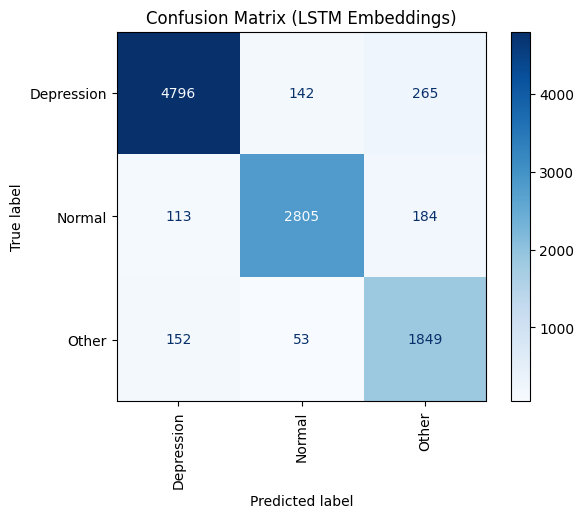

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test_true_lstm_weight_classes, y_test_pred_lstm_weight_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder_lstm_weight.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix (LSTM Embeddings)")
plt.show()

---

# Step 5: DistilBERT Transformer with LSTM Classifier Model

In [ ]:
# Set seeds for repeatability
def set_seeds(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

# Load DistilBERT tokenizer and model
distilbert_model_name = "distilbert-base-uncased"
tokenizer_distilbert_lstm_weight = DistilBertTokenizer.from_pretrained(distilbert_model_name)
distilbert_model = TFDistilBertModel.from_pretrained(distilbert_model_name)

def generate_distilbert_embeddings_batched(texts, batch_size=256, max_length=100):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer_distilbert_lstm_weight(
            batch_texts.tolist(),
            return_tensors="tf",
            padding="max_length",
            truncation=True,
            max_length=max_length
        )
        outputs = distilbert_model(inputs["input_ids"], attention_mask=inputs["attention_mask"])
        embeddings.append(outputs.last_hidden_state)
    return tf.concat(embeddings, axis=0)

X_train_sample = X_train[:20000]
X_train_embeddings = generate_distilbert_embeddings_batched(X_train_sample, batch_size=256)
y_train_sample = y_train[:20000]

# Generate embeddings for datasets
X_val_embeddings = generate_distilbert_embeddings_batched(X_val)
X_test_embeddings = generate_distilbert_embeddings_batched(X_test)

# Encode Labels
label_encoder_distilbert_lstm_weight = LabelEncoder()
y_train_encoded = label_encoder_distilbert_lstm_weight.fit_transform(y_train_sample)
y_val_encoded = label_encoder_distilbert_lstm_weight.transform(y_val)
y_test_encoded = label_encoder_distilbert_lstm_weight.transform(y_test)

num_classes = len(label_encoder_distilbert_lstm_weight.classes_)
y_train_categorical = to_categorical(y_train_encoded, num_classes)
y_val_categorical = to_categorical(y_val_encoded, num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Class Weights: {0: 0.6614412805503191, 1: 1.1124089215195505, 2: 1.6972165648336728}


## Transformer Embedding with a Bidirectional LSTM

In [ ]:
# Set seeds for repeatability
def set_seeds(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

# Define the model with Bidirectional LSTM layer
def build_model_distilbert_bidirectional_lstm(hp):
    inputs = Input(shape=(X_train_embeddings.shape[1], X_train_embeddings.shape[2]))

    # Multi-head attention
    attn_output = MultiHeadAttention(
        num_heads=hp.Choice("num_heads", values=[4, 8]),
        key_dim=hp.Choice("key_dim", values=[64])
    )(inputs, inputs)
    attn_output = Add()([inputs, attn_output])
    attn_output = LayerNormalization()(attn_output)

    # Bidirectional LSTM layer
    x = Bidirectional(
        LSTM(hp.Int("lstm_units", min_value=64, max_value=256, step=64), dropout=0.3, return_sequences=False)
    )(attn_output)

    # Fully connected layers
    x = Dense(hp.Choice("dense_units", values=[64, 128]), activation="relu")(x)
    x = Dropout(hp.Float("dropout_dense", min_value=0.3, max_value=0.5, step=0.1))(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    # Compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", values=[1e-4, 5e-4])),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


# Early stopping
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

# Initialize the tuner
tuner = kt.BayesianOptimization(
    build_model_distilbert_bidirectional_lstm,
    objective="val_accuracy",
    max_trials=48,
    directory="hyperparameter_tuning",
    project_name="distilbert_bidirectional_lstm"
)

# Perform hyperparameter tuning
tuner.search(
    X_train_embeddings, y_train_categorical,
    validation_data=(X_val_embeddings, y_val_categorical),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping]
)

# Train the model with best hyperparameters
best_hps_distilbert_bidirectional_lstm = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps_distilbert_bidirectional_lstm.values)

best_model_distilbert_bidirectional_lstm = tuner.hypermodel.build(best_hps_distilbert_bidirectional_lstm)
history = best_model_distilbert_bidirectional_lstm.fit(
    X_train_embeddings, y_train_categorical,
    validation_data=(X_val_embeddings, y_val_categorical),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

# Evaluate on the test set
test_loss, test_accuracy = best_model_distilbert_bidirectional_lstm.evaluate(X_test_embeddings, y_test_categorical)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Trial 48 Complete [00h 27m 48s]
val_accuracy: 0.9219353199005127

Best val_accuracy So Far: 0.9280887842178345
Total elapsed time: 1d 02h 11m 09s
Best Hyperparameters: {'num_heads': 4, 'key_dim': 64, 'lstm_units': 128, 'dense_units': 64, 'dropout_dense': 0.4, 'learning_rate': 0.0001}
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 130ms/step - accuracy: 0.7342 - loss: 0.6198 - val_accuracy: 0.8874 - val_loss: 0.3107
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step - accuracy: 0.8871 - loss: 0.3174 - val_accuracy: 0.8990 - val_loss: 0.2865
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step - accuracy: 0.9042 - loss: 0.2648 - val_accuracy: 0.9091 - val_loss: 0.2523
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 129ms/step - accuracy: 0.9143 - loss: 0.2356 - val_accuracy: 0.9118 - val_loss: 0.2515
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 129ms/step - accuracy: 0.9260 - loss: 0.2084 - val_accuracy: 0.9155 - val_loss: 0.2439
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 130ms/step - acc

In [ ]:
# Define the save directory
save_dir = "distilbert_lstm_best_model"
os.makedirs(save_dir, exist_ok=True)

# Save the fine-tuned best model
best_model_distilbert_bidirectional_lstm.save(os.path.join(save_dir, "best_model.keras"))

# Save the tokenizer
tokenizer_distilbert_lstm_weight.save_pretrained(save_dir)

# Save the label encoder
label_encoder_distilbert_lstm_weight_path = os.path.join(save_dir, "label_encoder_distilbert_lstm_weight.pkl")
with open(label_encoder_distilbert_lstm_weight_path, "wb") as le_file:
    pickle.dump(label_encoder_distilbert_lstm_weight, le_file)

# Save the best hyperparameters
best_hps_path = os.path.join(save_dir, "best_hyperparameters.pkl")
with open(best_hps_path, "wb") as hp_file:
    pickle.dump(best_hps_distilbert_bidirectional_lstm.values, hp_file)

print(f"Best model, tokenizer, label encoder, and hyperparameters saved to {save_dir}")


Best model, tokenizer, label encoder, and hyperparameters saved to distilbert_lstm_best_model


In [ ]:
# Classification Report
y_test_pred_db_lstm = best_model_distilbert_bidirectional_lstm.predict(X_test_embeddings)
y_test_pred_db_lstm_classes = np.argmax(y_test_pred_db_lstm, axis=1)
y_test_true_db_lstm_classes = np.argmax(y_test_categorical, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_true_db_lstm_classes, y_test_pred_db_lstm_classes))

324/324 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      5203
           1       0.92      0.94      0.93      3102
           2       0.86      0.89      0.87      2054

    accuracy                           0.93     10359
   macro avg       0.91      0.92      0.92     10359
weighted avg       0.93      0.93      0.93     10359



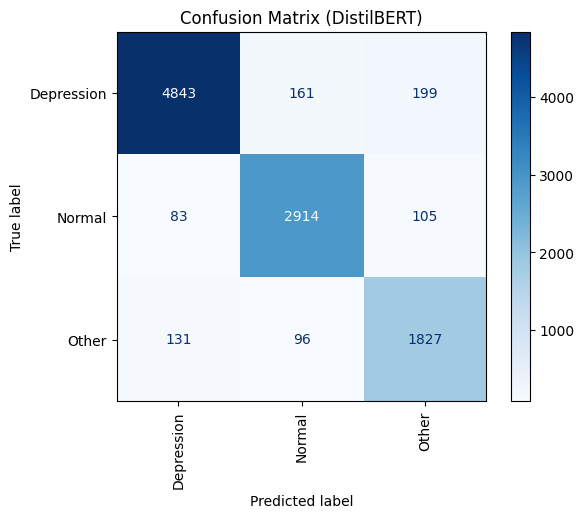

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test_true_db_lstm_classes, y_test_pred_db_lstm_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder_distilbert_lstm_weight.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix (DistilBERT)")
plt.show()

In [ ]:
# Define the save directory
save_dir = "distilbert_lstm_best_model"

# Load the Keras model
best_model = load_model(os.path.join(save_dir, "best_model.keras"))

# Load the tokenizer
tokenizer_distilbert_lstm_weight = DistilBertTokenizer.from_pretrained(save_dir)

# Load the label encoder
label_encoder_distilbert_lstm_weight_path = os.path.join(save_dir, "label_encoder_distilbert_lstm_weight.pkl")
with open(label_encoder_distilbert_lstm_weight_path, "rb") as le_file:
    label_encoder_distilbert_lstm_weight = pickle.load(le_file)

print("Model, tokenizer, and label encoder loaded successfully.")


Model, tokenizer, and label encoder loaded successfully.


In [ ]:
# Define the save directory
save_dir = "distilbert_lstm_best_model"

# Load the best model
best_model = load_model(os.path.join(save_dir, "best_model.keras"))

# Load the tokenizer
tokenizer_distilbert_lstm_weight = DistilBertTokenizer.from_pretrained(save_dir)

# Load the label encoder
label_encoder_distilbert_lstm_weight_path = os.path.join(save_dir, "label_encoder_distilbert_lstm_weight.pkl")
with open(label_encoder_distilbert_lstm_weight_path, "rb") as le_file:
    label_encoder_distilbert_lstm_weight = pickle.load(le_file)

# Load the best hyperparameters
best_hps_path = os.path.join(save_dir, "best_hyperparameters.pkl")
with open(best_hps_path, "rb") as hp_file:
    best_hyperparameters = pickle.load(hp_file)

print("Best model, tokenizer, label encoder, and hyperparameters loaded successfully.")
print("Best Hyperparameters:", best_hyperparameters)


Best model, tokenizer, label encoder, and hyperparameters loaded successfully.
Best Hyperparameters: {'num_heads': 4, 'key_dim': 64, 'lstm_units': 128, 'dense_units': 64, 'dropout_dense': 0.4, 'learning_rate': 0.0001}
